In [1]:
import pennylane as qml
import pennylane.numpy as np
from model import Model

In [2]:
name = 'phong_2_paralel'
def func(n, phi):
    return np.cos(phi) ** n
consts = {'ks': 0.5}
scalars = {'n': {'range':(2,2), 'type': np.uint32}}
angles = {'phi': {'range':(0, np.pi / 2)}}

In [3]:
model = Model()
model.set_name(name)
model.set_function(func)
# model.set_consts(consts)
model.set_scalars(scalars)
model.set_angles(angles)
try:
	model.read_samples('samples/' + model.name + '.bin')
except FileNotFoundError:
	model.generate_samples()
	model.read_samples('samples/' + model.name + '.bin')

model.separate()

(<Figure size 2700x500 with 1 Axes>, <Axes: >)

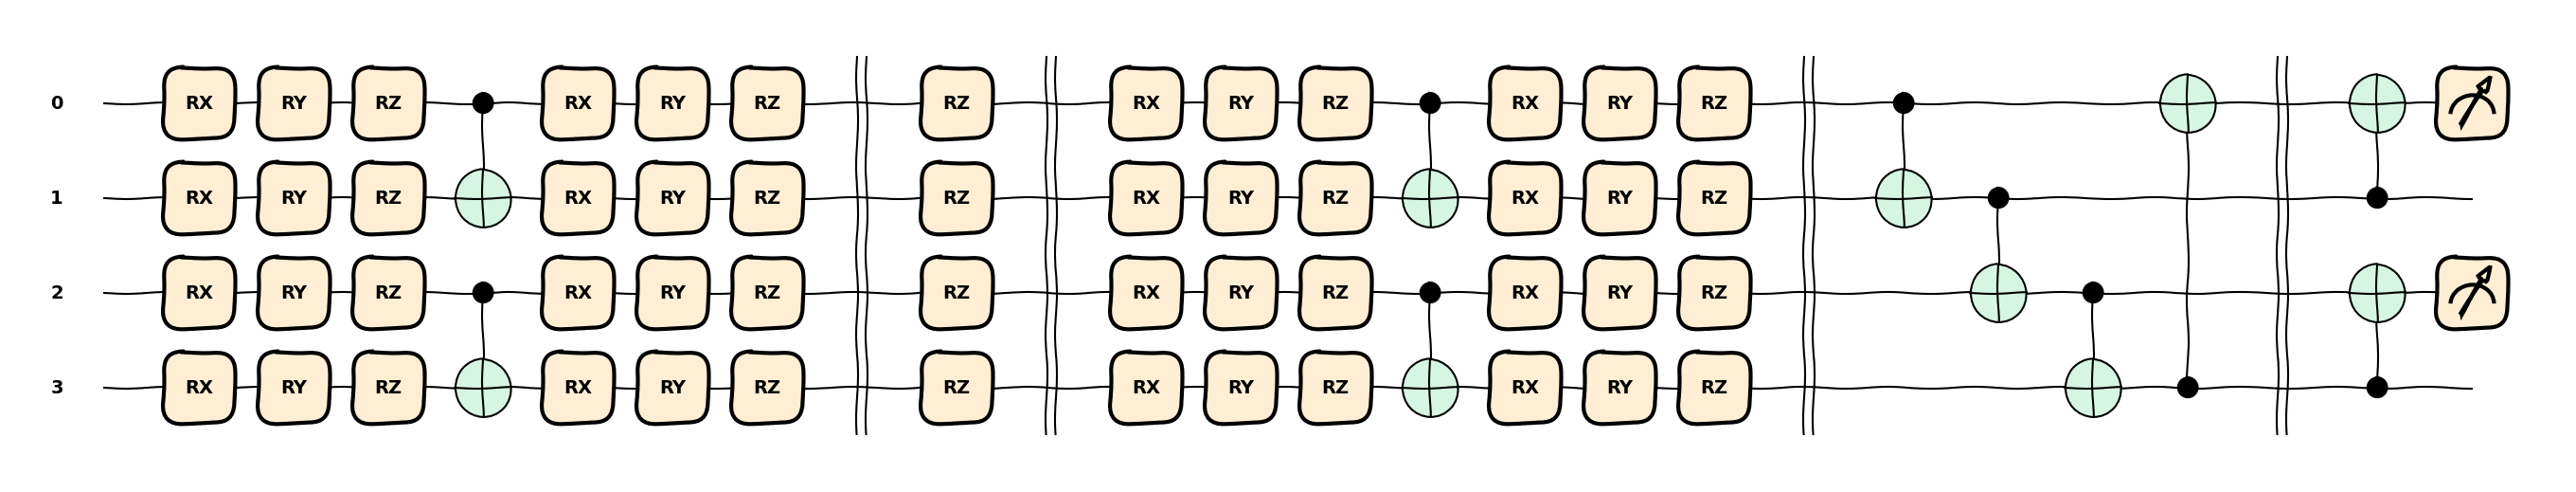

In [4]:
n_qubits = 2
paralel = 2
layers = 1

model.generate_device(n_qubits * paralel)

def embedding(data, n_qubits):
	for i in range(n_qubits):
		value = data[i]
		if i < len(model.scalars):
			name = model.header[i + len(model.consts)]
			(min, max) = model.scalars.get(name).get('range')
			if min == max:
				value = value / max * np.pi / 2
			else:
				value = (value - min) / (max - min) * np.pi

		for j in range(paralel):
			qml.RZ(value * 2**j, wires=i * paralel + j)

	qml.Barrier()

def neuron(params, n_qubits):
	if len(params) < n_qubits * 3:
		raise ValueError('Not enough params')

	for i in range(n_qubits):
		for j in range(paralel):
			qml.RX(params[( i * paralel + j) * 3], wires=i * paralel + j)
			qml.RY(params[( i * paralel + j) * 3 + 1], wires=i * paralel + j)
			qml.RZ(params[( i * paralel + j) * 3 + 2], wires=i * paralel + j)

	for i in range(n_qubits):
		for j in range(paralel - 1):
			qml.CNOT(wires= [i * paralel + j, i * paralel + j+1])

	for i in range(n_qubits):
		for j in range(paralel):
			qml.RX(params[n_qubits * paralel * 3 + (i * paralel + j) * 3], wires=i * paralel + j)
			qml.RY(params[n_qubits * paralel * 3 + (i * paralel + j) * 3 + 1], wires=i * paralel + j)
			qml.RZ(params[n_qubits * paralel * 3 + (i * paralel + j) * 3 + 2], wires=i * paralel + j)

	qml.Barrier()

def ent(n_qubits):
	for i in range(n_qubits * paralel):
		qml.CNOT(wires=[i , (i+1) % (n_qubits * paralel)])

	qml.Barrier()

	return

def end(n_qubits):
	for i in range(n_qubits):
		for j in range(paralel - 1, 0, -1):
			qml.CNOT(wires=[i * paralel + j, i * paralel])

	return

def _circuit(data, params):
	for i in range(layers):
		neuron(params[2 * i * (n_qubits * paralel * 3 * 2): (2 * i + 1) * (n_qubits * paralel * 3 * 2)], n_qubits)

		embedding(data, n_qubits)

		neuron(params[(2 * i + 1) * (n_qubits * paralel * 3 * 2): (2 * (i + 1)) * (n_qubits * paralel * 3 * 2)], n_qubits)

		ent(n_qubits)

	end(n_qubits)

	return qml.expval(qml.PauliZ(0) @ qml.PauliZ(paralel))

def _model(circ, input, params):
	return circ(input, params)

model.set_model(_model)
model.set_circuit(_circuit)
model.generate_params((n_qubits * paralel * 12 * layers,))

qml.draw_mpl(model.circuit, style='sketch')(model.train_in, model.params)

In [5]:
model.optimization(callback= True)

Step 0 -> Loss: 0.33594118135770196
Step 1 -> Loss: 0.5856443231000531
Step 2 -> Loss: 0.3621236286065821
Step 3 -> Loss: 0.3800000446048471
Step 4 -> Loss: 0.40906601744023263
Step 5 -> Loss: 0.3275658514793464
Step 6 -> Loss: 0.24799790838387037
Step 7 -> Loss: 0.1750463094900892
Step 8 -> Loss: 0.09290935256558422
Step 9 -> Loss: 0.0351157124443044
Step 10 -> Loss: 0.02088811297783087
Step 11 -> Loss: 0.016190036841157402
Step 12 -> Loss: 0.021536349115620208
Step 13 -> Loss: 0.03667678351452876
Step 14 -> Loss: 0.03694464356772951
Step 15 -> Loss: 0.037773224667675465
Step 16 -> Loss: 0.04128011826819533
Step 17 -> Loss: 0.03790600253374708
Step 18 -> Loss: 0.02708125625023174
Step 19 -> Loss: 0.015961279711798077
Step 20 -> Loss: 0.010398626461169319
Step 21 -> Loss: 0.008942124049502823
Step 22 -> Loss: 0.0066477576459697185
Step 23 -> Loss: 0.0032194911270216984
Step 24 -> Loss: 0.0018116636149164045
Step 25 -> Loss: 0.002698673508406812
Step 26 -> Loss: 0.003193496261524546
Ste

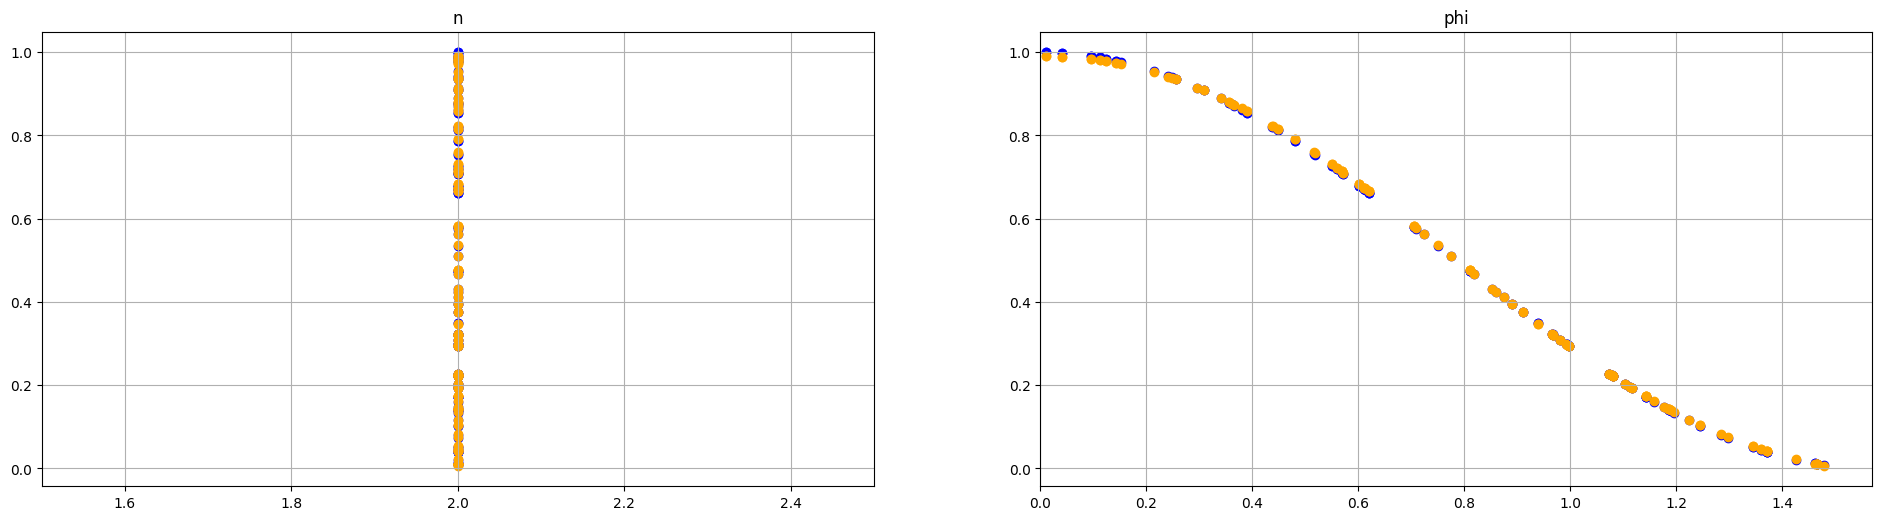

In [6]:
model.draw()

In [8]:
print('Test score:', model.test())

Test score: 1.0388180885937394e-05


In [7]:
model.serialize('models/' + model.name + '.json')